In [1]:
from datetime import datetime
import os
import tempfile
from glob import glob
from pathlib import Path
this_path = Path().resolve()
from sklearn.model_selection import train_test_split
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from torch.utils import tensorboard

from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch
import monai
import torchmetrics
from monai.transforms import (
    EnsureChannelFirst,
    Compose,
    RandRotate90,
    Resize,
    ResizeWithPadOrCrop,
    RandAdjustContrast,
    RandBiasField,
    RandAffine,
    ScaleIntensity,
)
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import SimpleITK as sitk
from utils.general_utils import save_sitk_from_nda
from dataset.ppmi_dataset import PPMIDataModule
from dataset.hmri_dataset import HMRIDataModule
from models.pl_model import Model
from utils.utils import get_pretrained_model, predict_from_ckpt
# monai.config.print_config()

2023-04-21 12:03:27,152 - Created a temporary directory at /tmp/tmpniwbwm45
2023-04-21 12:03:27,153 - Writing /tmp/tmpniwbwm45/_remote_module_non_scriptable.py


In [9]:
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
md_df_hc = md_df.loc[md_df.group == 1, :]
ids = list(md_df_hc['id'].values)
ids_int = [int(i.split('-')[-1]) for i in ids]
ids_int.sort()
ids_int

[3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 23,
 24,
 25,
 29,
 31,
 35,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 45,
 46,
 49,
 52,
 53,
 55,
 56,
 58,
 59,
 61,
 62,
 63,
 65,
 66,
 70,
 71,
 72,
 73,
 74]

In [10]:
dir_path = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/templates/t1wimgs/mb_template_PD/template_outs_PD')
template_path = dir_path/'mu_mb_pd.nii'  # 'softmax_mb_test.nii'
# '/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/templates/t1wimgs/mb_template_HC/result/pd25_PD25-subcortical-1mm.nii'
# '/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/templates/t1wimgs/mb_template_HC/template_outs_HC/y_1_00001_ss_msub-003_ses-01prisma3t_echo-01_part-magnitude-acq-T1w_MPM_mb_test.nii'
img = sitk.ReadImage('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/templates/t1wimgs/mb_template_PD/result/pd25_PD25-subcortical-1mm.nii')
print(img.GetSize())
img_nda = sitk.GetArrayFromImage(img)
print(img_nda.shape)

(243, 338, 359)
(359, 338, 243)


In [11]:
img.GetPixelIDTypeAsString()
img_cast = sitk.Cast(img, sitk.sitkUInt8)
img_cast.GetPixelIDTypeAsString()
sitk.WriteImage(img_cast, '/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/templates/t1wimgs/mb_template_PD/result/pd25_PD25-subcortical-1mm_uint8.nii')

In [13]:
img_cast.GetPixelIDTypeAsString()

'8-bit unsigned integer'

In [27]:
np.unique(img_nda)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.], dtype=float32)

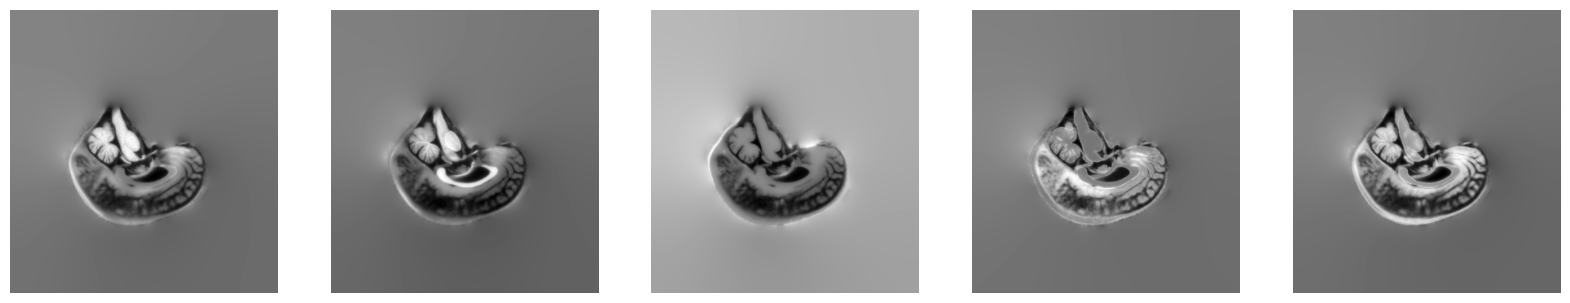

In [17]:
f, ax = plt.subplots(1, img_nda.shape[0], figsize=(20, 20))
for i in range(img_nda.shape[0]):
    # print(i)
    ax[i].imshow(img_nda[i, :, :, 107], cmap='gray')
    ax[i].axis('off')

In [20]:
for i in range(img_nda.shape[0]):
    save_sitk_from_nda(img_nda[i, :, :, :], dir_path.parent/f'result/mu_mb_test_c{i}.nii', img)

RuntimeError: Exception thrown in SimpleITK Image_SetDirection: /home/francesco/SimpleElastix/Code/Common/include/sitkTemplateFunctions.h:192:
sitk::ERROR: Length of input (16) does not match matrix dimensions (3, 3).


In [2]:
from datetime import datetime
import os
import tempfile
from glob import glob
from pathlib import Path
from sklearn.model_selection import train_test_split
from torch import optim, nn, utils, Tensor, as_tensor
from torch.utils.data import random_split, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import monai
import torchmetrics
import pandas as pd
import torchio as tio
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pytorch_lightning.loggers import TensorBoardLogger, CSVLogger
import yaml
from dataset.hmri_dataset import HMRIDataModule
from models.pl_model import Model, get_3dresnet
from utils.utils import get_pretrained_model
this_path = Path().resolve()

2023-04-13 11:35:49,370 - Created a temporary directory at /tmp/tmponn_i07c
2023-04-13 11:35:49,372 - Writing /tmp/tmponn_i07c/_remote_module_non_scriptable.py


In [3]:
with open('config.yaml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]
# Set data directory
root_dir = Path('/mnt/projects/7TPD/bids/derivatives/hMRI_acu/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

# create PPMI dataset
augmentations = tio.Compose([                                        
                            tio.RandomAffine(scales=(0.15, 0.15, 0.15), 
                                            degrees=(15, 0, 15),
                                            # isotropic=True,
                                            # center='image',
                                            default_pad_value=0),
                            # # tio.RandomElasticDeformation(p=0.1, num_control_points=7, max_displacement=10),
                            tio.RandomGamma(p=0.5),
                            # # tio.RandomNoise(p=0.5, mean=0.5, std=0.05), # p=0.5
                            # # tio.RandomMotion(p=0.1), #, degrees=20, translation=20),
                            # # tio.RandomBiasField(p=0.25),
                            ])

# save augmentations to config file                                   
cfg['aug'] = str(augmentations)

data = HMRIDataModule(md_df=md_df,
                    root_dir=root_dir,
                    augment=augmentations,
                    **cfg['dataset'])
data.prepare_data()
data.setup()

------------
 Data - PD: 49, HC: 23
Drop subjects ['sub-058', 'sub-016']


<class 'torch.Tensor'> torch.Size([3, 1, 180, 180, 180]) tensor([[0., 1.],
        [0., 1.],
        [1., 0.]]) torch.Size([3, 2])


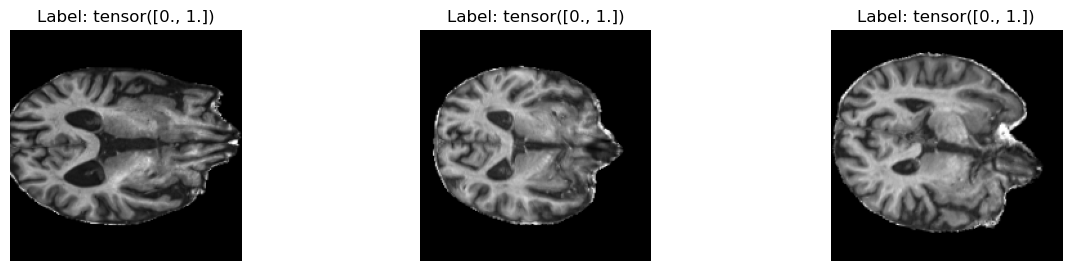

In [6]:
for i, subjects_batch in enumerate(data.train_dataloader()):
    # print(data.md_df_val.iloc[i, 0])
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

subj = 0
f,axs = plt.subplots(1,inputs.shape[0], figsize=(15, 3))
for i in range(inputs.shape[0]):
    axs[i].imshow(inputs[i].cpu().detach().numpy()[0, :, :, 90], cmap='gray')
    axs[i].set_title(f'Label: {target[subj]}')
    axs[i].axis('off')

In [4]:
model = Model(**cfg['model'])
# for i, (n, p) in enumerate(list(model.net.named_parameters())):
#     # print(p) if 'conv_seg' in n else None
#     if i == 0:
#         print(n, p.shape)
#         print(p)
#         break

Non-pretrained model is created.
Pretrained 3D resnet has a single input channel


In [11]:
model.net.conv_seg[3].in_features

512

In [7]:
for n,p in list(model.net.named_modules()):
    print(n)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu
layer1.0.conv2
layer1.0.bn2
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer4
layer4.0
layer4.0.conv1
layer4.0.bn1
layer4.0.relu
layer4.0.conv2
layer4.0.bn2
layer4.0.downsample
layer4.0.downsample.0
layer4.0.downsample.1
conv_seg
conv_seg.0
conv_seg.1
conv_seg.2
conv_seg.3


In [4]:
# create model
pretrained_model = get_pretrained_model(chkpt_path=Path(cfg['model']['chkpt_path']),
                                input_channels=cfg['model']['in_channels'])
model = Model(net=pretrained_model.net, **cfg['model'])

for i, (n, p) in enumerate(list(model.net.named_parameters())):
    # print(p) if 'conv_seg' in n else None
    if i == 0:
        print(n, p.shape)
        print(p)
        break

Pretrained 3D resnet has a single input channel
conv1.weight torch.Size([64, 1, 7, 7, 7])
Parameter containing:
tensor([[[[[ 1.6689e-02, -6.0281e-03, -2.9589e-03,  ..., -9.9496e-03,
            -7.6451e-03,  1.3921e-02],
           [ 2.3728e-02,  1.0338e-02,  1.1580e-02,  ...,  2.4769e-02,
            -1.1262e-02,  2.5927e-03],
           [-3.8420e-03,  1.7449e-02, -3.2542e-04,  ...,  1.3397e-03,
            -1.3752e-03, -1.1379e-03],
           ...,
           [ 2.1535e-02,  1.1300e-02,  7.9978e-03,  ..., -1.0345e-03,
             1.4733e-02,  1.5129e-02],
           [ 9.6669e-03,  1.1569e-02,  7.3558e-03,  ...,  2.0772e-02,
             1.7414e-02, -8.4308e-03],
           [ 6.1539e-03,  6.0711e-03,  2.9699e-02,  ...,  4.0489e-03,
             2.5110e-02,  1.9625e-02]],

          [[ 1.7758e-03,  4.8460e-03,  5.4963e-03,  ..., -5.6443e-03,
            -9.1688e-03,  1.8687e-02],
           [ 5.8169e-03, -2.3508e-04,  1.1833e-02,  ...,  1.3055e-03,
             9.2231e-04,  2.0414e-04]

In [9]:
for i, (n, p) in enumerate(list(model.net.named_parameters())):
    # print(p) if 'conv_seg' in n else None
    if i == 1:
        print(n, p.shape)
        print(p)
        break

conv_seg.3.weight
conv_seg.3.bias


In [7]:
for n,p in list(model.net.conv_seg.named_parameters()):
    print(n)

3.weight
3.bias


In [11]:

for i, m in enumerate(model.net.conv_seg.modules()):
    if isinstance(m, nn.Linear):
        print(i)
        print(m)
    
    # if isinstance(m, nn.Conv3d):
    #     m.weight = nn.init.kaiming_normal_(m.weight, mode='fan_out')

4
Linear(in_features=512, out_features=2, bias=True)


In [3]:
# predict with the best model
exp_name = '3dresnet-da00_lrsch_focal_sgd01_rs128'
ckpt_name = 'epoch=39-val_acc=0.8177.ckpt'
exp_dir = Path(this_path / f'outputs/{exp_name}/version_0')
ckpt_path = exp_dir / 'checkpoints' / ckpt_name

with open(exp_dir.parent /'config_dump.yml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

print(cfg)

{'aug': 'Compose([])', 'dataset': {'random_state': 70, 'reshape_size': 200, 'train_batch_size': 5, 'train_num_workers': 2, 'val_batch_size': 5, 'val_num_workers': 2}, 'exp_name': '3dresnet-da00_lrsch_focal_sgd01_rs128', 'model': {'in_channels': 1, 'learning_rate': 0.01, 'loss': 'focal', 'n_classes': 2, 'net': '3dresnet', 'optimizer_class': 'sgd', 'sch_patience': 10}, 'pl_trainer': {'accelerator': 'gpu', 'devices': [0], 'log_every_n_steps': 10, 'max_epochs': 50, 'precision': 16}}


In [4]:
# create PPMI dataset

# read metadata file and get the first scan for each subject
root_dir = Path("/mnt/scratch/7TPD/mpm_run_acu/PPMI")
md_df = pd.read_csv(root_dir/'t1_3d_3t_1mm_pdhc_2_16_2023.csv')
md_df['Acq Date'] = md_df['Acq Date'].apply(pd.to_datetime)
md_df.sort_values(by='Acq Date', inplace=True)
first_acq_idx = md_df.duplicated(subset=['Subject'])
md_df_first = md_df.loc[~first_acq_idx, :]

# create dataset
data = PPMIDataModule(md_df=md_df_first, root_dir=root_dir, **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

# obtain the dataloader
test_dl = data.test_dataloader()
val_dl = data.val_dataloader()
train_dl = data.train_dataloader()

# create model
# model = Model(**cfg['model'])
# model.load_from_checkpoint(ckpt_path, **cfg['model'])
model = Model.load_from_checkpoint(ckpt_path, **cfg['model'])
model.eval()

Training:   288
Validation:  96
Test:       97


Model(
  (criterion): BinaryFocalLossWithLogits()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
  (train_auroc): BinaryAUROC()
  (val_auroc): BinaryAUROC()
  (train_f1): BinaryF1Score()
  (val_f1): BinaryF1Score()
  (net): ResNet(
    (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn2): BatchNorm3d(64, eps=1e-05, momen

In [2]:
import numpy as np
from scipy.linalg import toeplitz
# from niedu.utils.nipa import generate_labels

N_per_run = 40
M = 4  # nr of runs
K = 1000  # nr of voxels

# Generate random data drawn for a multivariate normal
# distribution with AR1 noise (with phi = 0.85) to
# simulate autocorrelated noise in the estimated patterns,
# which is plausible for designs with relatively short ISIs
mu = np.zeros(N_per_run)
V = 0.85 ** toeplitz(np.arange(N_per_run))

# R_runs is a list of M arrays of shape N_per_run x K
R_runs = [np.random.multivariate_normal(mu, V, size=K).T for _ in range(M)]

# S_runs is a list of M arrays of shape N_per_run
# The custom generate_label function creates slightly correlated
# labels
# S_runs = [generate_labels(['M', 'F'], N_per_run / 2, [0.7, 0.3]) for _ in range(M)]

print("Example of patterns for run 1:\n", R_runs[0])
# print("\nExample of target for run 1:\n", S_runs[0])

Example of patterns for run 1:
 [[-0.20097359 -0.55989096  0.33244694 ...  0.71259495  0.52978096
   0.42608425]
 [ 0.31897304 -1.29032207  0.09381078 ...  0.46288111 -0.02980719
   0.32637214]
 [-0.1989147  -1.25417803  1.25137296 ...  0.34982437 -0.15088257
   0.16287322]
 ...
 [-0.43201893  0.03752764 -1.54862617 ...  0.35040606  0.95417488
  -0.32199134]
 [-0.23849729 -0.3962994  -1.60257723 ...  0.77416362  1.17854581
  -0.20645462]
 [ 0.67559915 -0.34658809 -1.32782135 ...  0.13635283  0.97523147
   0.07873897]]


In [3]:
np.shape(R_runs)

(4, 40, 1000)

In [12]:
# read the config file
with open('config.yaml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

# Set data directory
root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

augmentations = tio.Compose([tio.RandomAffine(scales=(0.15, 0.15, 0.15), 
                                                degrees=(15, 0, 15),
                                                # isotropic=True,
                                                center='image',
                                                default_pad_value=0)])
# cfg['dataset']['train_batch_size'] = 1
# cfg['dataset']['val_batch_size'] = 1

data = HMRIDataModule(md_df=md_df,
                        root_dir=root_dir,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

------------
 Data - PD: 49, HC: 23
Drop subjects ['sub-058', 'sub-016', 'sub-025']
Training:   41
Validation:  14
Test:       14


In [13]:
for i, subjects_batch in enumerate(data.train_dataloader()):
    print(data.md_df_val.iloc[i, 0])
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

sub-048
<class 'torch.Tensor'> torch.Size([3, 4, 180, 180, 180]) tensor([[1., 0.],
        [0., 1.],
        [0., 1.]]) torch.Size([3, 2])


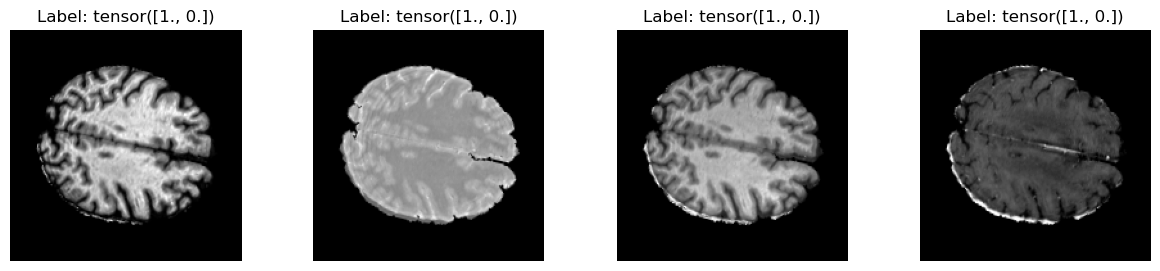

In [16]:
subj = 0
f,axs = plt.subplots(1,4, figsize=(15, 3))
for i in range(4):
    axs[i].imshow(inputs[subj].cpu().detach().numpy()[i, :, :, 120], cmap='gray')
    axs[i].set_title(f'Label: {target[subj]}')
    axs[i].axis('off')

#### Check predictions - hMRI data
##### Val and train

In [2]:
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix

In [3]:
def get_scores(path: str):
    ckpt_path = Path(path)
    all_scores = {}
    for split in ['train', 'val', 'test']:
        scores = {}
        y_hat, data = predict_from_ckpt(ckpt_path, dataloader=split, return_preds=False, dataset='hmri')
        if split == 'train':
            y = data.md_df_train['group'].values
        elif split == 'val':
            y = data.md_df_val['group'].values
        else:
            y = data.md_df_test['group'].values
        f1 = f1_score(y, np.asarray(y_hat), average='weighted')
        acc = balanced_accuracy_score(y, np.asarray(y_hat))
        scores['f1'] = f1
        scores['acc'] = acc
        print(f'{split} f1: {f1:.4f}, acc: {acc:.4f}')
        print(confusion_matrix(y, np.asarray(y_hat)))
        all_scores[split] = scores

    return all_scores

In [4]:
path_exp = '/home/alejandrocu/Documents/parkinson_classification/p1_hmri_outs/hmri3dresnet-da01_bz1_focal_adam_lr0.001_windowed_r42/version_0/checkpoints/epoch=42-val_f1=0.8889.ckpt'
exp_scores = get_scores(path_exp)

Drop subjects 058, 016
2023-03-07 17:44:15,243 - GPU available: True (cuda), used: True
2023-03-07 17:44:15,244 - TPU available: False, using: 0 TPU cores
2023-03-07 17:44:15,244 - IPU available: False, using: 0 IPUs
2023-03-07 17:44:15,244 - HPU available: False, using: 0 HPUs
2023-03-07 17:44:15,246 - You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-03-07 17:44:15,251 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3. ...
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

train f1: 0.6282, acc: 0.6071
[[ 8  6]
 [10 18]]
Drop subjects 058, 016
2023-03-07 17:45:37,808 - GPU available: True (cuda), used: True
2023-03-07 17:45:37,808 - TPU available: False, using: 0 TPU cores
2023-03-07 17:45:37,809 - IPU available: False, using: 0 IPUs
2023-03-07 17:45:37,809 - HPU available: False, using: 0 HPUs
2023-03-07 17:45:37,810 - You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-03-07 17:45:37,813 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3. ...
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

val f1: 0.8398, acc: 0.7500
[[ 2  2]
 [ 0 10]]
Drop subjects 058, 016
2023-03-07 17:45:52,498 - GPU available: True (cuda), used: True
2023-03-07 17:45:52,499 - TPU available: False, using: 0 TPU cores
2023-03-07 17:45:52,499 - IPU available: False, using: 0 IPUs
2023-03-07 17:45:52,500 - HPU available: False, using: 0 HPUs
2023-03-07 17:45:52,501 - You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-03-07 17:45:52,504 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3. ...
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

test f1: 0.4638, acc: 0.4000
[[0 5]
 [2 8]]


In [5]:
exp_scores

{'train': {'f1': 0.6282051282051283, 'acc': 0.6071428571428572},
 'val': {'f1': 0.8398268398268397, 'acc': 0.75},
 'test': {'f1': 0.463768115942029, 'acc': 0.4}}

In [5]:
ckpt_path = Path('/home/alejandrocu/Documents/parkinson_classification/p1_hmri_outs/hmri3dresnet-da00_bz3_BCE_adam_lr0.001_windowed/version_0/checkpoints/epoch=04-val_f1=0.7143.ckpt')
y_hat, preds, data = predict_from_ckpt(ckpt_path, dataloader='train', return_preds=True, dataset='hmri')

Drop subjects 058, 016
Training:   42
Validation:  14
Test:       15
2023-03-06 17:22:06,068 - GPU available: True (cuda), used: True
2023-03-06 17:22:06,069 - TPU available: False, using: 0 TPU cores
2023-03-06 17:22:06,069 - IPU available: False, using: 0 IPUs
2023-03-06 17:22:06,069 - HPU available: False, using: 0 HPUs
2023-03-06 17:22:06,071 - You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-03-06 17:22:06,074 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3. ...
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers

Predicting: 0it [00:00, ?it/s]

In [18]:
f1_s = f1_score(data.md_df_train['group'].values, np.asarray(y_hat), average='macro')
print(f'f1 score {f1_s}')

f1 score 0.5073313782991202


In [17]:
np.asarray(y_hat)

array([1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

#### Testing dataloader error

In [2]:
with open('config.yaml', 'r') as f:
        cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

# Set data directory
root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

# create PPMI dataset
augmentations = tio.Compose([
                                    
                                #     tio.RandomAffine(scales=(0.15, 0.15, 0.15), 
                                #                     degrees=(10, 0, 10),
                                #                     # isotropic=True,
                                #                     # center='image',
                                #                     default_pad_value=0),
                                #     # # tio.RandomElasticDeformation(p=0.1, num_control_points=7, max_displacement=10),
                                #     tio.RandomGamma(p=0.5),
                                    # # tio.RandomNoise(p=0.5, mean=0.5, std=0.05), # p=0.5
                                    # # tio.RandomMotion(p=0.1), #, degrees=20, translation=20),
                                    # # tio.RandomBiasField(p=0.25),
                                    ])
# cfg['dataset']['train_batch_size'] = 3
data = HMRIDataModule(md_df=md_df,
                        root_dir=root_dir,
                        augment=augmentations,
                        shuffle=False,
                        **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

train_dl = data.train_dataloader()

------------
 Data - PD: 49, HC: 23
Drop subjects 058, 016
Training:   42
Validation:  14
Test:       14


In [3]:
for i, subjects_batch in enumerate(train_dl):
    print(i)
    if i == 0:
        inputs = subjects_batch['image'][tio.DATA]
        target = subjects_batch['label']        
        break
print(type(inputs), inputs.shape, target, target.shape)

0
<class 'torch.Tensor'> torch.Size([3, 4, 200, 200, 200]) tensor([[0., 1.],
        [0., 1.],
        [0., 1.]]) torch.Size([3, 2])


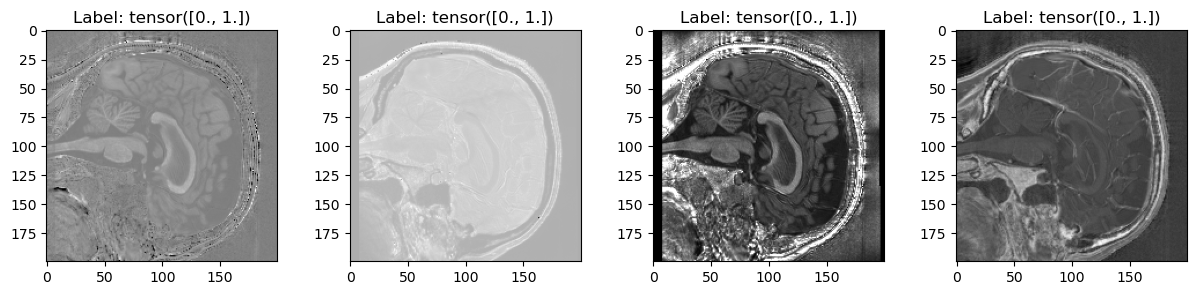

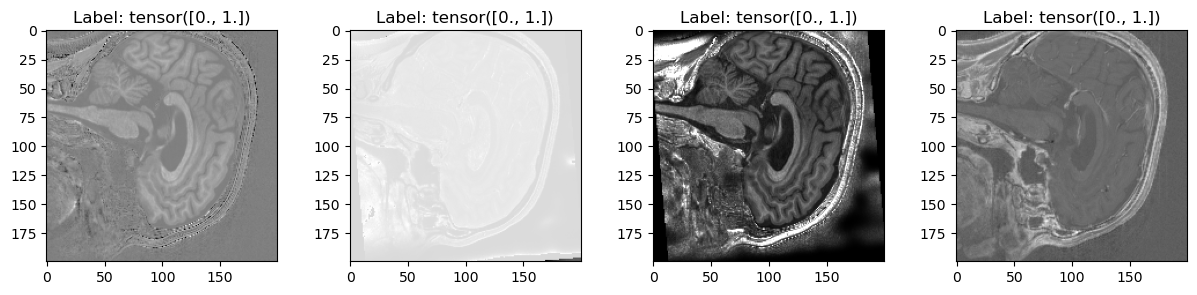

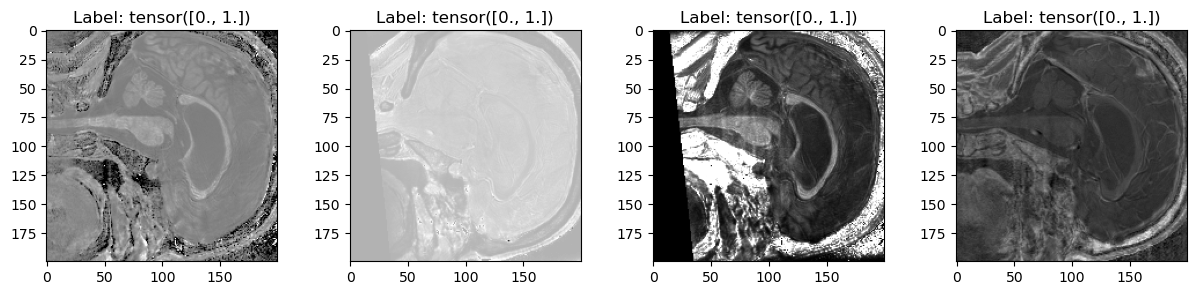

In [4]:
for j in range(3):
    subj = j
    f,axs = plt.subplots(1,4, figsize=(15, 3))
    for i in range(4):
        axs[i].imshow(inputs[subj].cpu().detach().numpy()[i, 100, :, :], cmap='gray')
        axs[i].set_title(f'Label: {target[subj]}')

In [13]:
df = data.md_df_train
print(df.loc[df.id == 'sub-072', :].index)
# df.drop(df[df.id == ['sub-016', 'sub-072']].index, inplace=True)
# df.drop([13, 68], inplace=True)
df

Int64Index([], dtype='int64')


,id,s01-7t,s01-3t,s02-7t,s03-7t,group
7,sub-010,True,True,True,True,1
58,sub-062,True,True,False,False,1
26,sub-029,True,True,True,True,1
31,sub-034,True,True,True,True,0
42,sub-045,True,True,True,True,1
49,sub-052,True,True,True,True,1
18,sub-021,True,True,False,False,1
0,sub-003,True,True,False,False,1
59,sub-063,True,True,False,False,1
24,sub-027,True,True,False,False,0


#### Creating model for hMRI dataset

In [2]:
this_path = Path().resolve()

# read the config file
with open('config.yaml', 'r') as f:
    cfg = list(yaml.load_all(f, yaml.SafeLoader))[0]

# Set data directory
root_dir = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

# create PPMI dataset
augmentations = tio.Compose([
                                    
                                    tio.RandomAffine(scales=(0.1, 0.1, 0.1), 
                                                    degrees=(10, 0, 10),
                                                    # isotropic=True,
                                                    # center='image',
                                                    default_pad_value=0)
                                    # tio.RandomElasticDeformation(p=0.1, num_control_points=7, max_displacement=10),
                                    # tio.RandomGamma(p=0.5),
                                    # tio.RandomNoise(p=0.5, mean=0.5, std=0.05), # p=0.5
                                    # tio.RandomMotion(p=0.1), #, degrees=20, translation=20),
                                    # tio.RandomBiasField(p=0.25),
                                    ])

# save augmentations to config file                                   
cfg['aug'] = str(augmentations)
print(cfg)

------------
 Data - PD: 49, HC: 23
{'pl_trainer': {'max_epochs': 50, 'devices': [0], 'accelerator': 'gpu', 'precision': 16, 'log_every_n_steps': 10}, 'training': {'early_stopping': False, 'monitor_ckpt': 'val_f1'}, 'dataset': {'train_num_workers': 2, 'train_batch_size': 5, 'val_num_workers': 2, 'val_batch_size': 5, 'reshape_size': 200, 'random_state': 42, 'weighted_sampler': False}, 'model': {'chkpt_path': '/home/alejandrocu/Documents/parkinson_classification/p1_ppmi_outs/3dresnet-da01_bz10_focal_sampler/version_0/checkpoints/epoch=01-val_f1=0.7708.ckpt', 'n_classes': 2, 'in_channels': 4, 'loss': 'focal', 'optimizer_class': 'sgd', 'learning_rate': 0.01, 'sch_patience': 10, 'momentum': 0}, 'exp_name': 'hmri3dresnet-da00_bz5_focal', 'aug': 'Compose([RandomAffine()])'}


In [3]:
pretrained_model = get_pretrained_model(chkpt_path=Path(cfg['model']['chkpt_path']),
                                 input_channels=cfg['model']['in_channels'])
pretrained_model.net

ResNet(
  (conv1): Conv3d(4, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, 

In [4]:
model = Model(net=pretrained_model.net, **cfg['model'])

In [8]:
path_chkpt = Path('/home/alejandrocu/Documents/parkinson_classification/p1_ppmi_outs/3dresnet-da01_bz10_focal_sampler/version_0/checkpoints/epoch=01-val_f1=0.7708.ckpt')
print(path_chkpt.parent.parent.parent)

/home/alejandrocu/Documents/parkinson_classification/p1_ppmi_outs/3dresnet-da01_bz10_focal_sampler


In [13]:
str_sample = '3dresnet-da01_bz10_focal_sampler'
if not isinstance(str_sample, str):
    print('yes')
else:
    print('no')

no


In [10]:
if '3dresnet' in path_chkpt.parent.parent.parent.name:
    print('3dresnet pretrained')

3dresnet pretrained


In [8]:
# Set data directory
data_path = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

augmentations = tio.Compose([])
data_hmri = HMRIDataModule(md_df=md_df,
                        root_dir=data_path,
                        augment=augmentations,
                        **cfg['dataset'])
data_hmri.prepare_data()
data_hmri.setup()
print("Training:  ", len(data_hmri.train_set))
print("Validation: ", len(data_hmri.val_set))
print("Test:      ", len(data_hmri.test_set))

# model = Model.load_from_checkpoint(ckpt_path, **cfg['model'])
# model.eval()

------------
 Data - PD: 49, HC: 23
Drop subject 058 because it doesn't have maps
Training:   42
Validation:  14
Test:       15


In [7]:
model.net.conv1 = torch.nn.Conv3d(in_channels= 4, 
                                  out_channels=64, 
                                  kernel_size=(7, 7, 7), 
                                  stride=(2, 2, 2), 
                                  padding=(3, 3, 3), 
                                  bias=False)
print(model.net)

ResNet(
  (conv1): Conv3d(4, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(128, eps=1e-05, momentum=0.1, 

#### Train dL

In [4]:
trainer = pl.Trainer(accelerator='gpu') #
predictions_train = trainer.predict(model, dataloaders=train_dl)

2023-02-27 11:10:19,786 - GPU available: True (cuda), used: True
2023-02-27 11:10:19,787 - TPU available: False, using: 0 TPU cores
2023-02-27 11:10:19,788 - IPU available: False, using: 0 IPUs
2023-02-27 11:10:19,788 - HPU available: False, using: 0 HPUs
2023-02-27 11:10:19,790 - You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-02-27 11:10:19,793 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3. ...
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:488: PossibleUserWarning: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers

Predicting: 0it [00:00, ?it/s]

In [5]:
predictions_train

[tensor([[-3.0490,  3.0291],
         [-2.9815,  3.0837],
         [-4.5817,  4.4686],
         [-3.4305,  3.2872],
         [-3.2221,  3.3926]]),
 tensor([[-4.3788,  4.4709],
         [-3.3644,  3.2800],
         [-2.3720,  2.3687],
         [-0.9099,  0.9694],
         [-2.4703,  2.5830]]),
 tensor([[-2.3461,  2.3748],
         [-2.7814,  2.9124],
         [-2.9362,  2.9038],
         [ 1.9840, -1.9366],
         [-2.9913,  3.1567]]),
 tensor([[-3.8463,  4.0559],
         [-4.0000,  4.1309],
         [-3.1186,  2.8593],
         [-4.7299,  4.6089],
         [-3.7122,  3.6824]]),
 tensor([[ 2.6051, -2.4363],
         [-2.9449,  3.1113],
         [-3.4848,  3.4380],
         [-0.6961,  0.8120],
         [-5.7788,  5.9549]]),
 tensor([[-2.1500,  2.0953],
         [ 2.9356, -2.7078],
         [-3.7565,  3.6918],
         [ 2.5807, -2.3966],
         [-5.1960,  5.2267]]),
 tensor([[-2.5601,  2.6800],
         [ 2.2683, -2.1264],
         [-4.0877,  4.2415],
         [-4.3038,  4.4068],
  

In [6]:
preds = [item for sublist in predictions_train for item in sublist]
preds_sf = [torch.softmax(item, dim=0) for item in preds]
y_hat = [torch.argmax(item).cpu().numpy() for item in preds_sf]

In [7]:
train_labels = [torch.max(item['label'], 0)[1].cpu().numpy() for item in data.train_set]
train_res = pd.DataFrame([train_labels, y_hat]).T
train_res.columns = ['label', 'pred']
train_res['correct'] = train_res['label'] == train_res['pred']
train_res

,label,pred,correct
0,0,1,False
1,0,1,False
2,1,1,True
3,1,1,True
4,0,1,False
...,...,...,...
283,0,1,False
284,0,1,False
285,0,0,True
286,0,1,False


In [8]:
print(train_res['correct'].value_counts())
print(train_res['label'].value_counts())
print(train_res['pred'].value_counts())

False    188
True     100
Name: correct, dtype: int64
0    223
1     65
Name: label, dtype: int64
1    223
0     65
Name: pred, dtype: int64


In [9]:
188/(288)

0.6527777777777778

#### Val dL

In [10]:
trainer = pl.Trainer(accelerator='gpu') #
predictions = trainer.predict(model, dataloaders=val_dl)

2023-02-27 11:21:08,466 - GPU available: True (cuda), used: True
2023-02-27 11:21:08,466 - TPU available: False, using: 0 TPU cores
2023-02-27 11:21:08,466 - IPU available: False, using: 0 IPUs
2023-02-27 11:21:08,467 - HPU available: False, using: 0 HPUs
2023-02-27 11:21:08,468 - You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
2023-02-27 11:21:08,490 - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/lightning_fabric/plugins/environments/slurm.py:166: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3. ...
  rank_zero_warn(
/mrhome/alejandrocu/anaconda3/envs/7tpd/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [11]:
predictions

[tensor([[-0.2068,  0.1725],
         [ 0.3278, -0.2846],
         [-2.1050,  2.3348],
         [ 0.2582, -0.0663],
         [-1.7950,  1.7166]]),
 tensor([[-2.3669,  2.3111],
         [-0.0984,  0.1664],
         [-2.1417,  2.1970],
         [-1.3301,  1.4171],
         [-2.3311,  2.4499]]),
 tensor([[-3.0341,  3.0945],
         [-2.1840,  2.0880],
         [-2.4393,  2.5056],
         [-2.7879,  2.7273],
         [-0.8004,  0.8098]]),
 tensor([[-1.9818,  1.9867],
         [-3.2560,  3.2697],
         [-0.0730,  0.1380],
         [-1.1507,  1.2572],
         [-1.9517,  2.0791]]),
 tensor([[-2.6508,  2.6429],
         [-0.3142,  0.2016],
         [-3.4411,  3.3302],
         [ 0.6299, -0.5126],
         [-2.8758,  2.8740]]),
 tensor([[-1.5688,  1.5722],
         [-3.0440,  3.0840],
         [-3.3633,  3.2898],
         [-0.7796,  0.9073],
         [-2.3363,  2.6041]]),
 tensor([[-2.2111,  2.1766],
         [-1.1820,  1.3503],
         [-2.2319,  2.1338],
         [-1.5198,  1.7097],
  

In [12]:
preds = [item for sublist in predictions for item in sublist]
preds_sf = [torch.softmax(item, dim=0) for item in preds]
y_hat = [torch.argmax(item).cpu().numpy() for item in preds_sf]

In [13]:
data.md_df_val

,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
713,I287902,3311,PD,M,75,BL,MRI,MPRAGE GRAPPA,Original,2012-01-31,DCM,NaN
446,I368584,3638,PD,M,66,BL,MRI,SAG T1 3D MPRAGE,Original,2013-04-02,DCM,NaN
737,I372986,3191,Control,F,66,BL,MRI,SAG MPRAGE GRAPPA,Original,2013-05-02,DCM,NaN
470,I243291,3610,Control,F,60,BL,MRI,SAG T1 3D MPRAGE,Original,2011-05-24,DCM,NaN
681,I378541,3332,PD,M,74,BL,MRI,MPRAGE GRAPPA,Original,2013-04-23,DCM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
469,I243297,3611,Control,F,42,BL,MRI,SAG T1 3D MPRAGE,Original,2011-05-25,DCM,NaN
399,I337731,3775,PD,M,63,BL,MRI,MPRAGE GRAPPA,Original,2012-05-30,DCM,NaN
94,I554270,40893,PD,M,71,V04,MRI,MPRAGE w/ GRAPPA,Original,2015-03-24,DCM,NaN
967,I1642716,121109,PD,F,57,BL,MRI,MPRAGE,Original,2022-11-03,DCM,NaN


In [14]:
val_labels = [torch.max(item['label'], 0)[1].cpu().numpy() for item in data.val_set]
val_res = pd.DataFrame([val_labels, y_hat]).T
val_res.columns = ['label', 'pred']
val_res['correct'] = val_res['label'] == val_res['pred']
val_res

,label,pred,correct
0,0,1,False
1,0,0,True
2,1,1,True
3,1,0,False
4,0,1,False
...,...,...,...
91,1,1,True
92,0,1,False
93,0,1,False
94,0,1,False


In [15]:
print('correct \n', val_res['correct'].value_counts())
print('labels \n', val_res['label'].value_counts())
print('preds \n', val_res['pred'].value_counts())

correct 
 False    78
True     18
Name: correct, dtype: int64
labels 
 0    74
1    22
Name: label, dtype: int64
preds 
 1    90
0     6
Name: pred, dtype: int64


In [14]:
print('acc', 18/96)

acc 0.1875


### Dev

In [3]:
cfg['dataset']

{'random_state': 70,
 'reshape_size': 200,
 'train_batch_size': 5,
 'train_num_workers': 2,
 'val_batch_size': 5,
 'val_num_workers': 2}

In [58]:
# create PPMI dataset

# read metadata file and get the first scan for each subject
root_dir = Path("/mnt/scratch/7TPD/mpm_run_acu/PPMI")
md_df = pd.read_csv(root_dir/'t1_3d_3t_1mm_pdhc_2_16_2023.csv')
md_df['Acq Date'] = md_df['Acq Date'].apply(pd.to_datetime)
md_df.sort_values(by='Acq Date', inplace=True)
first_acq_idx = md_df.duplicated(subset=['Subject'])
md_df_first = md_df.loc[~first_acq_idx, :]

# create PPMI dataset
augmentations = tio.Compose([                                 
                                    tio.RandomAffine(scales=(0.1, 0.1, 0.1), 
                                                        degrees=(10, 0, 10),
                                                        center='image',
                                                        default_pad_value=0.5),
                                    # tio.RandomElasticDeformation(p=0.1, num_control_points=7, max_displacement=10),
                                    tio.RandomGamma(p=0.5),
                                    tio.RandomNoise(p=1, mean=0.5, std=0.01), # p=0.5]
                                    # tio.RandomMotion(p=0.1), #, degrees=20, translation=20),
                                    # tio.RandomBiasField(p=0.25),
                                    ])


data = PPMIDataModule(md_df=md_df_first, 
                        root_dir=root_dir, 
                        augment=augmentations, 
                        **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

# obtain the dataloader
test_dl = data.test_dataloader()
val_dl = data.val_dataloader()
train_dl = data.train_dataloader()

Training:   288
Validation:  96
Test:       97


In [59]:
data.transform

Compose([Compose([RescaleIntensity(out_min_max=(0, 1), percentiles=(0, 100), masking_method=None), CropOrPad()]), Compose([RandomAffine(), RandomGamma()])])

<class 'torch.Tensor'> torch.Size([5, 1, 200, 200, 200]) tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.]]) torch.Size([5, 2])


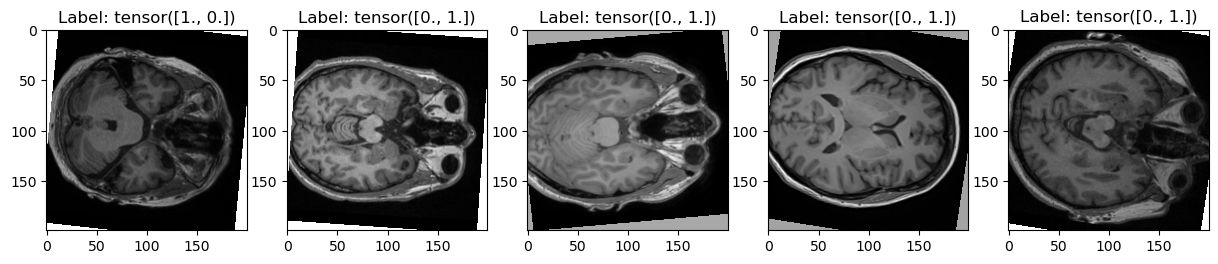

In [60]:
for subjects_batch in train_dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

f,axs = plt.subplots(1,5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(inputs[i].cpu().detach().numpy()[0, :, :, 100], cmap='gray')
    axs[i].set_title(f'Label: {target[i]}')
# plt.imshow(inputs[2].cpu().detach().numpy()[0, :, :, 70]) # , (1, 2, 3, 0)

In [16]:
def test_model(model, loader):
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    acc = torchmetrics.Accuracy(task='binary')
    auroc = torchmetrics.AUROC(task='binary')
    f1score = torchmetrics.F1Score(task='binary', num_classes=2, average='macro')
    with torch.no_grad():
        labels_all = []
        preds_all = []
        step_acc = {'acc': [], 'auroc': [], 'f1score': []}
        model.net.to_cuda()
        for batch in loader:
            # y_hat, y = model.infer_batch(batch)
            x, y = model.prepare_batch(batch)
            x, y = x.cuda(), y.cuda()
            y_hat = model.net(x)
            # print(y_hat)
            # print(y)
            step_acc['acc'].append(acc(y_hat, y).cpu().numpy())
            step_acc['auroc'].append(auroc(y_hat, y).cpu().numpy())
            step_acc['f1score'].append(f1score(y_hat, y).cpu().numpy())
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(y_hat.data, 1)
            total += y.size(0)
            correct += torch.sum(predicted == torch.max(y.data, 1)[1])
            labels_all.extend(y.cpu().numpy())
            preds_all.extend(predicted.cpu().numpy())
        print(f'Acc: {correct/total}')    
    return labels_all, preds_all, step_acc

In [17]:
val_labels, val_preds, step_acc = test_model(model, val_dl)

AttributeError: 'ResNet' object has no attribute 'to_cuda'

In [75]:
print(np.argmax(val_labels[0]), val_labels[0])

0 [1. 0.]


In [76]:
sum([np.argmax(i) for i in val_labels])

74

In [26]:
val_labels, val_preds = test_model(model, val_dl)

tensor([[ 2.0421e-14, -2.2780e-13],
        [ 3.2509e-14, -1.8618e-13],
        [ 1.5679e-14, -1.4702e-13],
        [ 1.7819e-14, -1.7926e-13],
        [ 2.7635e-14, -1.9061e-13]])
tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]])
tensor(0.5000)


In [46]:
val_labels.size(0)

5

In [40]:
_, predicted = torch.max(val_preds.data, 1)
print(predicted)

tensor([0, 0, 0, 0, 0])


In [44]:
torch.max(val_labels.data, 1)[1]

tensor([0, 0, 0, 0, 1])

In [45]:
torch.sum(predicted == torch.max(val_labels.data, 1)[1])

tensor(4)

In [32]:
torch.softmax(val_preds, dim=1)

tensor([[0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000],
        [0.5000, 0.5000]])

In [59]:
for subjects_batch in val_dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

<class 'torch.Tensor'> torch.Size([5, 1, 128, 128, 128]) tensor([[1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.]]) torch.Size([5, 2])


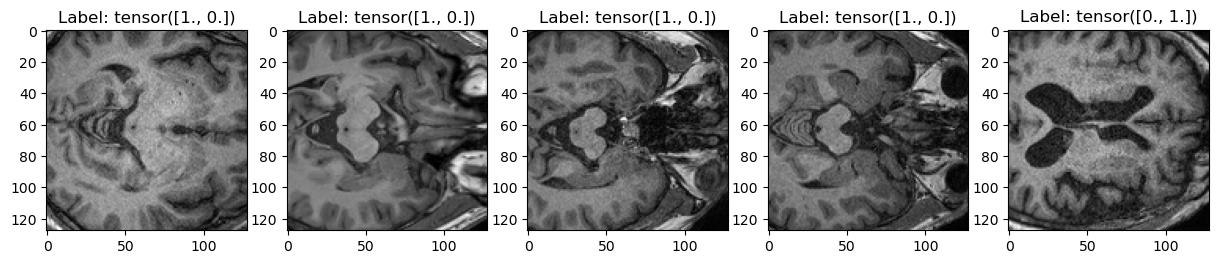

In [65]:
f,axs = plt.subplots(1,5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(inputs[i].cpu().detach().numpy()[0, :, :, 70], cmap='gray')
    axs[i].set_title(f'Label: {target[i]}')
# plt.imshow(inputs[2].cpu().detach().numpy()[0, :, :, 70]) # , (1, 2, 3, 0)

### hMRI Dataset

In [3]:
# Set data directory
data_path = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'Data - PD: {pd_number}, HC: {hc_number}')

Data - PD: 49, HC: 23


In [9]:
augmentations = tio.Compose([])
data = HMRIDataModule(md_df=md_df,
                        root_dir=data_path,
                        augment=augmentations,
                        **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

Drop subject 058 because it doesn't have maps
Training:   42
Validation:  14
Test:       15


In [7]:
data.train_set[0]['image']

ScalarImage(shape: (4, 200, 200, 200); spacing: (1.00, 1.00, 1.00); orientation: PSR+; dtype: torch.FloatTensor; memory: 122.1 MiB)

In [11]:
for subjects_batch in data.train_dataloader():
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)


<class 'torch.Tensor'> torch.Size([5, 4, 200, 200, 200]) tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.]]) torch.Size([5, 2])


In [17]:
inputs[0].squeeze().shape

torch.Size([4, 200, 200, 200])

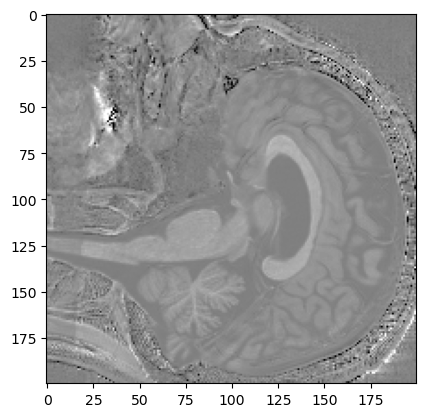

In [18]:
plt.imshow(inputs[0][0, :, :, 100], cmap='gray')

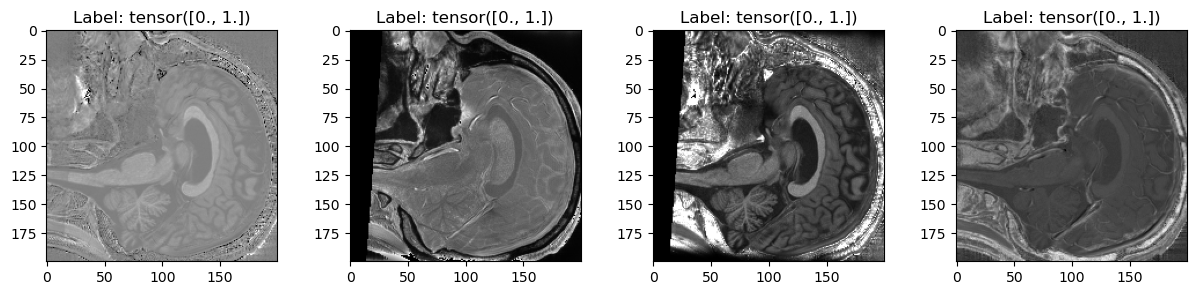

In [12]:
f,axs = plt.subplots(1,4, figsize=(15, 3))
for i in range(4):
    axs[i].imshow(inputs[0].cpu().detach().numpy()[i, :, :, 100], cmap='gray')
    axs[i].set_title(f'Label: {target[0]}')

In [12]:
subjects_list = []
subjects_labels = []
for i in range(len(md_df)):
    subj_dir = data_path / md_df.loc[i, 'id'] / 'Results'
    hmri_files = sorted(list(subj_dir.glob('*.nii')), key=lambda x: x.stem)
    subjects_list.append(hmri_files)
    subjects_labels.append(md_df.loc[i, 'group'])

In [ ]:
for i in range(len(md_df)):
    subj_dir = data_path / md_df.loc[i, 'id'] / 'Results'
    hmri_files = sorted(list(subj_dir.glob('*.nii')), key=lambda x: x.stem)
    break
print(hmri_files)

[PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-003/Results/sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_MTsat.nii'), PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-003/Results/sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_PD_R2scorr.nii'), PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-003/Results/sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R1.nii'), PosixPath('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI/sub-003/Results/sub-003_ses-01prisma3t_echo-01_part-magnitude-acq-MToff_MPM_R2s_WLS1.nii')]


### Checking orientations

In [3]:
augmentations = tio.Compose([])

# create PPMI dataset

# read metadata file and get the first scan for each subject
root_dir = Path("/mnt/scratch/7TPD/mpm_run_acu/PPMI")
md_df = pd.read_csv(root_dir/'t1_3d_3t_1mm_pdhc_2_16_2023.csv')
md_df['Acq Date'] = md_df['Acq Date'].apply(pd.to_datetime)
md_df.sort_values(by='Acq Date', inplace=True)
first_acq_idx = md_df.duplicated(subset=['Subject'])
md_df_first = md_df.loc[~first_acq_idx, :]

# create dataset
data = PPMIDataModule(md_df=md_df_first, 
                      root_dir=root_dir, 
                      augment=augmentations, 
                      **cfg['dataset'])
data.prepare_data()
data.setup()
print("Training:  ", len(data.train_set))
print("Validation: ", len(data.val_set))
print("Test:      ", len(data.test_set))

ppmi_val_dl = data.val_dataloader()

# Set data directory
data_path = Path('/mnt/scratch/7TPD/mpm_run_acu/bids/derivatives/hMRI')
md_df = pd.read_csv(this_path/'bids_3t.csv')
pd_number = len(md_df.loc[md_df.group == 1, :])
hc_number = len(md_df.loc[md_df.group == 0, :])
print(f'------------\n Data - PD: {pd_number}, HC: {hc_number}')

data_hmri = HMRIDataModule(md_df=md_df,
                        root_dir=data_path,
                        augment=augmentations,
                        **cfg['dataset'])
data_hmri.prepare_data()
data_hmri.setup()
print("Training:  ", len(data_hmri.train_set))
print("Validation: ", len(data_hmri.val_set))
print("Test:      ", len(data_hmri.test_set))

hmri_val_dl = data_hmri.val_dataloader()

Training:   288
Validation:  96
Test:       97
------------
 Data - PD: 49, HC: 23
Drop subject 058 because it doesn't have maps
Training:   42
Validation:  14
Test:       15


In [5]:
for subjects_batch in ppmi_val_dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

<class 'torch.Tensor'> torch.Size([5, 1, 200, 200, 200]) tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.]]) torch.Size([5, 2])


In [6]:
data.train_subjects[0]['image']

ScalarImage(shape: (1, 176, 240, 256); spacing: (1.00, 1.00, 1.00); orientation: RAS+; path: "/mnt/scratch/7TPD/mpm_run_acu/PPMI/3825/MPRAGE_GRAPPA/2012-07-03_10_36_56.0/S157163/PPMI_3825_MR_MPRAGE_GRAPPA__br_raw_20120710135828029_131_S157163_I315739.nii")

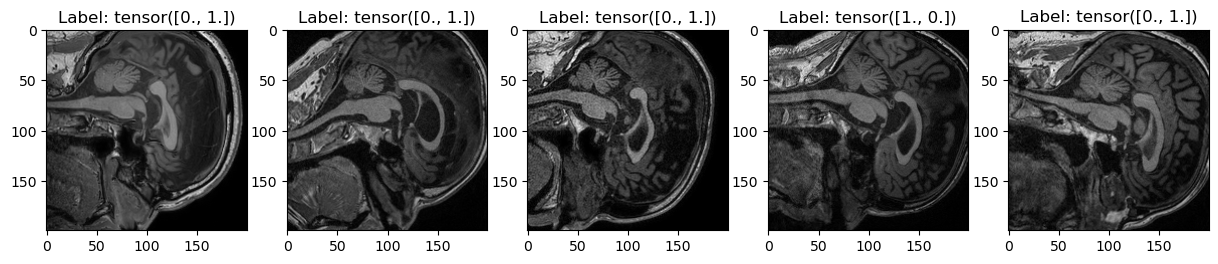

In [9]:
f,axs = plt.subplots(1,5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow(inputs[i].cpu().detach().numpy()[0, 100, :, :], cmap='gray')
    axs[i].set_title(f'Label: {target[i]}')

In [4]:
for subjects_batch in hmri_val_dl:
    inputs = subjects_batch['image'][tio.DATA]
    target = subjects_batch['label']
    break
print(type(inputs), inputs.shape, target, target.shape)

<class 'torch.Tensor'> torch.Size([5, 4, 200, 200, 200]) tensor([[0., 1.],
        [0., 1.],
        [0., 1.],
        [0., 1.],
        [1., 0.]]) torch.Size([5, 2])


In [5]:
data_hmri.train_subjects[0]['image']

ScalarImage(shape: (4, 240, 256, 176); spacing: (1.00, 1.00, 1.00); orientation: PSR+; dtype: torch.FloatTensor; memory: 165.0 MiB)

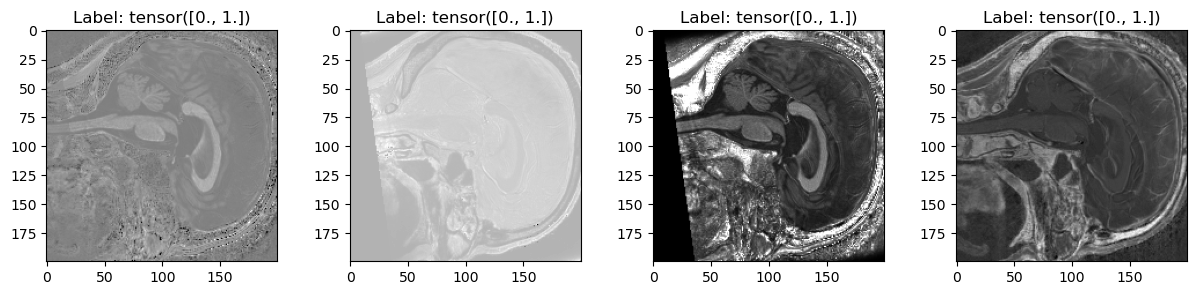

In [8]:
subj = 0
f,axs = plt.subplots(1,4, figsize=(15, 3))
for i in range(4):
    axs[i].imshow(inputs[subj].cpu().detach().numpy()[i, 100, :, :], cmap='gray')
    axs[i].set_title(f'Label: {target[subj]}')